In [146]:
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [136]:
# Load Dataframes from files
customer_profiles_table = pd.read_csv("./dataset/customer_profiles_table", index_col="CUSTOMER_ID")
terminal_profiles_table = pd.read_csv("./dataset/terminal_profiles_table", index_col="TERMINAL_ID")
transactions_df = pd.read_csv("./dataset/transactions_df")

In [137]:
# Convert datetime to pandas datetime
transactions_df['TX_DATETIME'] = pd.to_datetime(transactions_df['TX_DATETIME'])

In [13]:
customer_profiles_table.head()

,x_customer_id,y_customer_id,age,gender,income,credit_score,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
CUSTOMER_ID,,,,,,,,,,,
0,654,112,82.0,1,8437.372943,703.0,84.373729,42.186865,3.567092,"[193, 260, 477, 647, 1000, 1083, 1749, 1782, 1...",49
1,811,620,32.0,0,13286.538036,445.0,132.865380,66.432690,3.702387,"[694, 746, 781, 1214, 1391, 1507, 2582, 2988, ...",23
2,156,760,54.0,1,8123.775029,657.0,81.237750,40.618875,2.559684,"[383, 435, 938, 1244, 1413, 1703, 1932, 2936, ...",27
3,310,235,43.0,0,6804.114442,564.0,68.041144,34.020572,3.096935,"[351, 430, 2614, 3000, 3322, 3409, 4703, 5081,...",21
4,734,284,90.0,1,2317.466655,662.0,23.174667,11.587333,2.727281,"[99, 1246, 1354, 2065, 2242, 2786, 2980, 3068,...",32


In [52]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2020-01-01 00:01:10,2701,8587,124.50,70,0,0,0
1,1,2020-01-01 00:01:59,3305,6949,10.21,119,0,0,0
2,2,2020-01-01 00:03:12,53,8279,44.23,192,0,0,0
3,3,2020-01-01 00:03:27,4172,8647,9.72,207,0,0,0
4,4,2020-01-01 00:04:21,365,7996,153.45,261,0,0,0


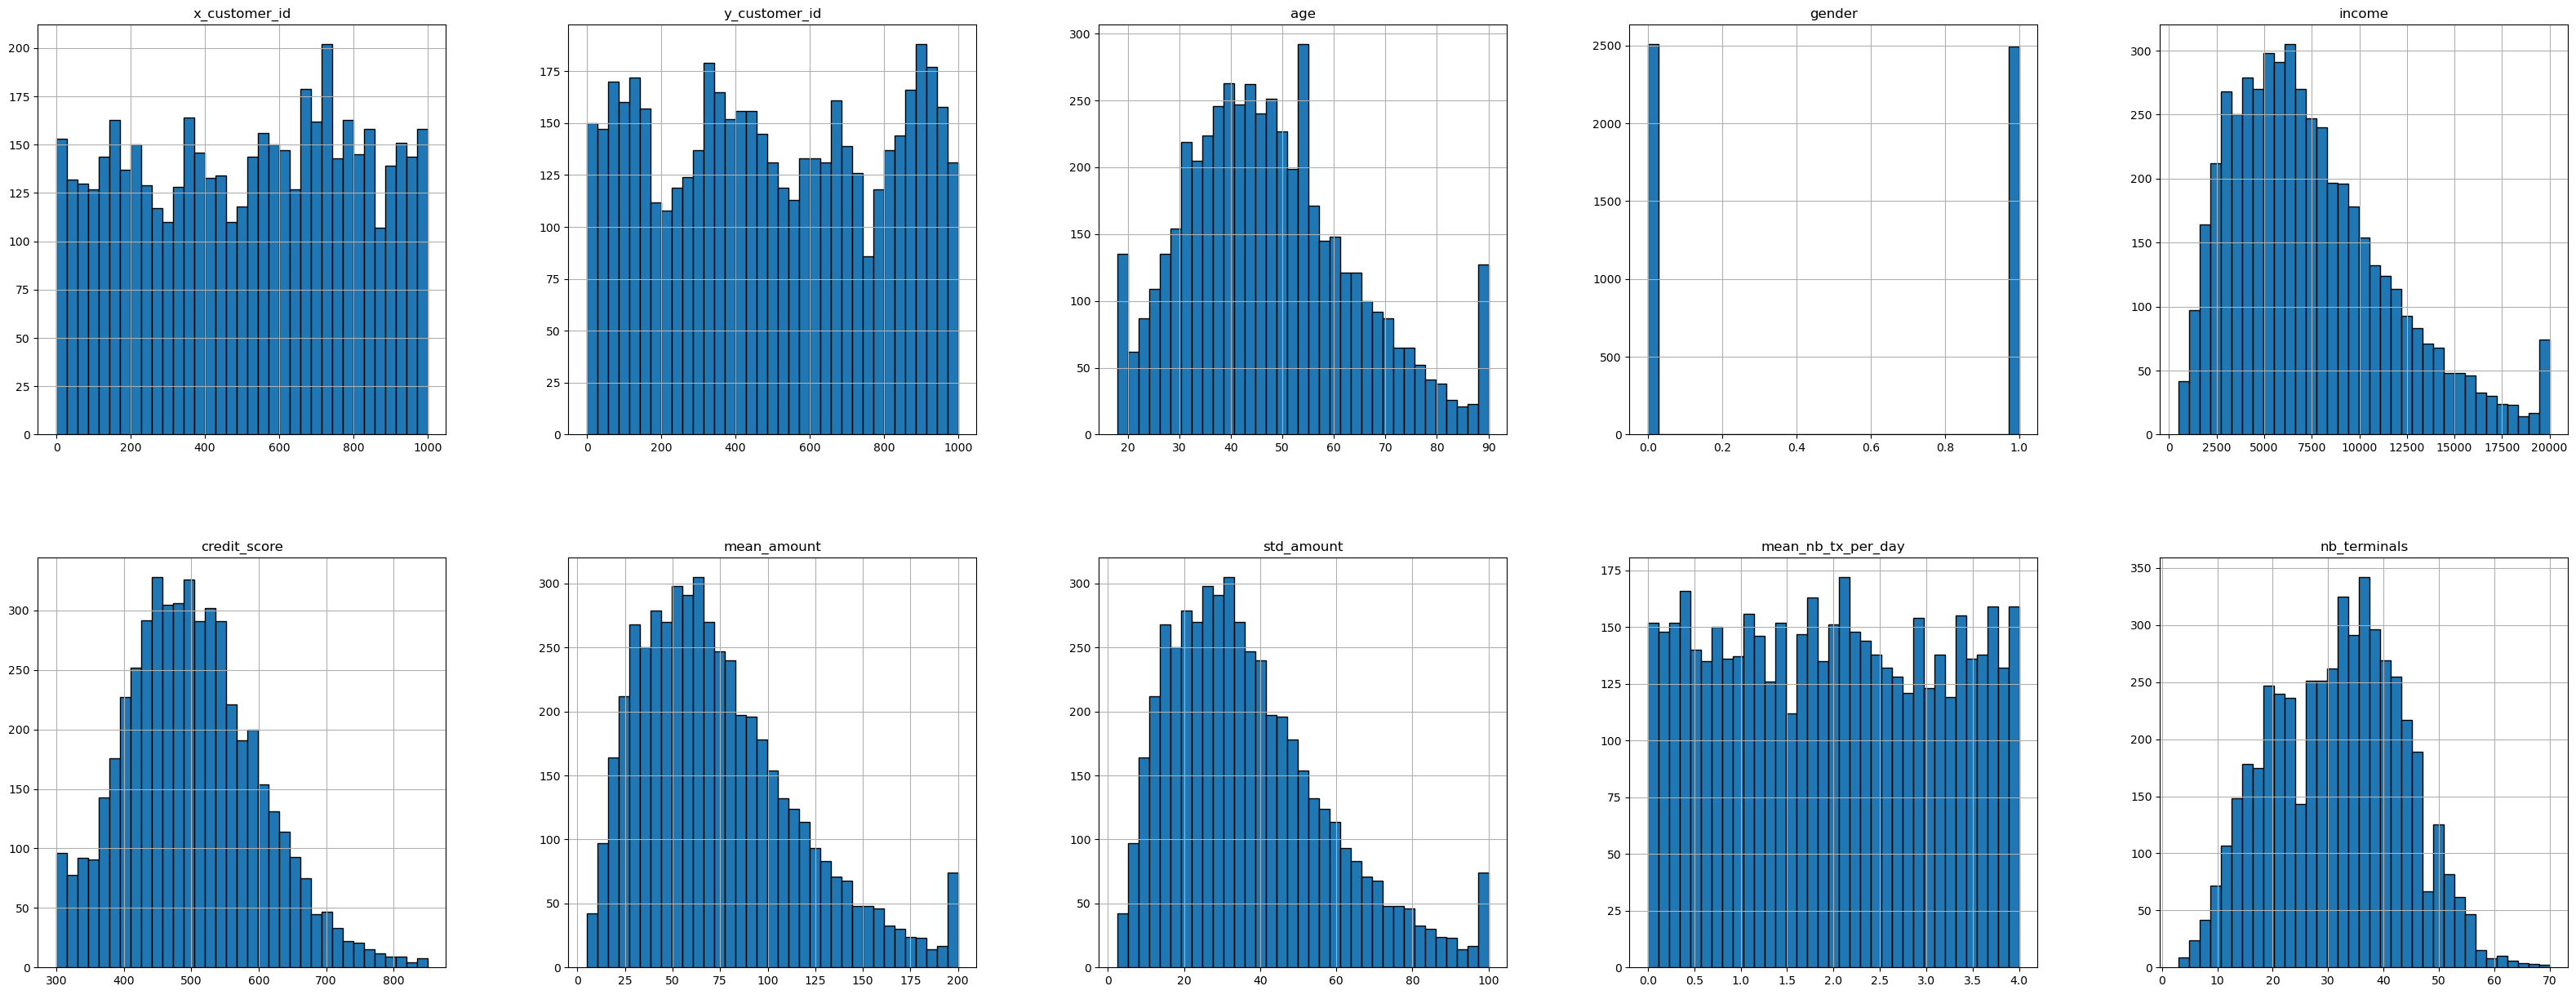

In [4]:
customer_profiles_table.hist(figsize=(40, 15), bins=35, edgecolor="black", layout=(2,5));

In [138]:
transactions_joined = transactions_df.merge(customer_profiles_table, on="CUSTOMER_ID", how="left")
transactions_joined = transactions_joined.merge(terminal_profiles_table, on="TERMINAL_ID", how="left")

In [84]:
transactions_joined.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,x_customer_id,...,gender,income,credit_score,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals,x_terminal_id,y_terminal_id
0,0,2020-01-01 00:01:10,2701,8587,124.50,70,0,0,0,698,...,0,10373.461460,458.0,103.734615,51.867307,3.624258,"[37, 80, 207, 275, 619, 704, 725, 880, 898, 10...",49,698,912
1,1,2020-01-01 00:01:59,3305,6949,10.21,119,0,0,0,878,...,0,804.733055,461.0,8.047331,4.023665,2.922509,"[20, 241, 749, 1341, 1690, 3687, 4102, 4277, 4...",26,891,901
2,2,2020-01-01 00:03:12,53,8279,44.23,192,0,0,0,545,...,0,5219.782095,523.0,52.197821,26.098910,1.636216,"[119, 1020, 1997, 2152, 2359, 4285, 4311, 4610...",19,543,949
3,3,2020-01-01 00:03:27,4172,8647,9.72,207,0,0,0,542,...,1,9130.251956,433.0,91.302520,45.651260,3.314625,"[16, 266, 405, 499, 555, 955, 998, 1033, 1132,...",41,533,333
4,4,2020-01-01 00:04:21,365,7996,153.45,261,0,0,0,932,...,1,11307.264345,438.0,113.072643,56.536322,0.975751,"[246, 624, 734, 1069, 1166, 1322, 1732, 2399, ...",25,943,869


In [139]:
# Drop excess columns
transactions_joined = transactions_joined.drop(labels=["TX_FRAUD_SCENARIO", "mean_amount","std_amount", "mean_nb_tx_per_day",
                                 "available_terminals", "nb_terminals"], axis=1)

In [21]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Order transactions chronologically
    customer_transactions = customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index = customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the number of transactions for the given window size
        NB_TX_WINDOW = customer_transactions['TX_AMOUNT'].rolling(str(window_size) + 'd').count()
    
        # Compute the average transaction amount for the given window size
        AVG_AMOUNT_TX_WINDOW = customer_transactions['TX_AMOUNT'].rolling(str(window_size) + 'd').mean()
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index = customer_transactions.TRANSACTION_ID
        
    return customer_transactions

In [140]:
# Generate customer deprendent features
transactions_joined = transactions_joined.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x))
transactions_joined = transactions_joined.sort_values('TX_DATETIME').reset_index(drop=True)

In [102]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    # Order transactions chronologically
    terminal_transactions = terminal_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    terminal_transactions.index = terminal_transactions.TX_DATETIME
    
    # Calculate delay values so we can later subtract them
    NB_FRAUD_DELAY = terminal_transactions['TX_FRAUD'].rolling(str(delay_period) + 'd').sum()
    NB_TX_DELAY = terminal_transactions['TX_FRAUD'].rolling(str(delay_period) + 'd').count()
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute how many fradulent transactions happened
        NB_FRAUD_DELAY_WINDOW = terminal_transactions['TX_FRAUD'].rolling(str(delay_period + window_size) + 'd').sum()
        NB_TX_DELAY_WINDOW = terminal_transactions['TX_FRAUD'].rolling(str(delay_period + window_size) + 'd').count()
    
        # Subtract delay values
        NB_FRAUD_WINDOW = NB_FRAUD_DELAY_WINDOW - NB_FRAUD_DELAY
        NB_TX_WINDOW = NB_TX_DELAY_WINDOW - NB_TX_DELAY
    
        # Calculate risk factor
        RISK_WINDOW = NB_FRAUD_WINDOW / NB_TX_WINDOW
        
        terminal_transactions[feature + '_NB_TX_' + str(window_size) + 'DAY_WINDOW'] = list(NB_TX_WINDOW)
        terminal_transactions[feature + '_RISK_' + str(window_size) + 'DAY_WINDOW'] = list(RISK_WINDOW)
    
    # Reindex
    terminal_transactions.index = terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0, inplace=True)
    
    return terminal_transactions


In [141]:
# Generate terminal deprendent features
transactions_joined = transactions_joined.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x))
transactions_joined = transactions_joined.sort_values('TX_DATETIME').reset_index(drop=True)

In [142]:
transactions_joined.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,x_customer_id,y_customer_id,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2020-01-01 00:01:10,2701,8587,124.50,70,0,0,698,931,...,1.0,124.50,1.0,124.50,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2020-01-01 00:01:59,3305,6949,10.21,119,0,0,878,919,...,1.0,10.21,1.0,10.21,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2020-01-01 00:03:12,53,8279,44.23,192,0,0,545,934,...,1.0,44.23,1.0,44.23,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2020-01-01 00:03:27,4172,8647,9.72,207,0,0,542,339,...,1.0,9.72,1.0,9.72,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2020-01-01 00:04:21,365,7996,153.45,261,0,0,932,884,...,1.0,153.45,1.0,153.45,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
# Drop excess columns
transactions_joined = transactions_joined.drop(["TRANSACTION_ID", "TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID",
                                                "TX_TIME_SECONDS", "TX_TIME_DAYS"], axis=1)

In [157]:
# Rescale data
scaler = StandardScaler()
transactions_scaled = scaler.fit_transform(transactions_joined)
transactions_scaled = pd.DataFrame(transactions_scaled, columns=['TX_AMOUNT', 'TX_FRAUD', 'x_customer_id', 'y_customer_id', 'age',
                                                                   'gender', 'income', 'credit_score', 'x_terminal_id', 'y_terminal_id',
                                                                   'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
                                                                   'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
                                                                   'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
                                                                   'TERMINAL_ID_NB_TX_1DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW',
                                                                   'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW',
                                                                   'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW'])

In [163]:
# Save DataFrames to files
transactions_scaled.to_csv("./dataset/transactions_scaled", index=False)

In [166]:
# Load Dataframes from files
transactions_scaled = pd.read_csv("./dataset/transactions_scaled")